<a href="https://colab.research.google.com/github/sanvirrafsaan/Data-Science-Portfolio/blob/main/Churn-prediction/notebooks/02_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import sys
from pathlib import Path

%cd /content
!rm -rf Data-Science-Portfolio
!git clone -q https://github.com/sanvirrafsaan/Data-Science-Portfolio.git
%cd /content/Data-Science-Portfolio/Churn-prediction

assert Path("pyproject.toml").exists()
assert Path("src/churn").exists()

!{sys.executable} -m pip -q install -e . --no-cache-dir

# Add the src directory to sys.path so the 'churn' module can be found
sys.path.insert(0, str(Path("src").resolve()))

import churn
from churn import utils, paths
print("✅ churn:", churn.__file__)
print("✅ utils:", utils.__file__)
print("✅ paths:", paths.__file__)

/content
/content/Data-Science-Portfolio/Churn-prediction
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for churn (pyproject.toml) ... done
✅ churn: /content/Data-Science-Portfolio/Churn-prediction/src/churn/__init__.py
✅ utils: /content/Data-Science-Portfolio/Churn-prediction/src/churn/utils.py
✅ paths: /content/Data-Science-Portfolio/Churn-prediction/src/churn/paths.py


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor
from churn.utils import best_grid_shape
from churn.paths import RAW_DIR, INTERIM_DIR
from churn.plots import (
    customized_pairplot,
    plot_categories_percentages,
    plot_category_distribution_by_target,
    plot_target_distribution_by_category
)

In [41]:
import os
from pathlib import Path
from google.colab import drive


drive.mount('/content/drive')
PROJECT_ROOT = Path("/content/drive/MyDrive/Data Science Portfolio/churn-prediction")

# --- Paths ---
RAW_DIR = PROJECT_ROOT / "data" / "raw"
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

# --- Ensure directories exist ---
for p in [RAW_DIR, INTERIM_DIR, PROCESSED_DIR, MODELS_DIR, FIGURES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# --- Debug ---
print("Project root:", PROJECT_ROOT)
print("Interim contents:", [x.name for x in INTERIM_DIR.iterdir()])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/MyDrive/Data Science Portfolio/churn-prediction
Interim contents: ['interim_data.parquet']


In [42]:
df = pd.read_parquet(f"{INTERIM_DIR}/interim_data.parquet")
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [44]:
df['Contract'].unique()

['Month-to-month', 'One year', 'Two year']
Categories (3, object): ['Month-to-month', 'One year', 'Two year']

#Numeric Columns
Next, lets look at the numeric columns and their relationship to the churn rate

In [45]:
numeric_features = sorted(df.select_dtypes(include="number").columns.to_list())

target = "Churn"

id_column = "customerID"

categorical_features = sorted(
    df.select_dtypes(include="category").columns.drop([target]).to_list()
)

Figure(1650x500)
[<Axes: > <Axes: > <Axes: >]


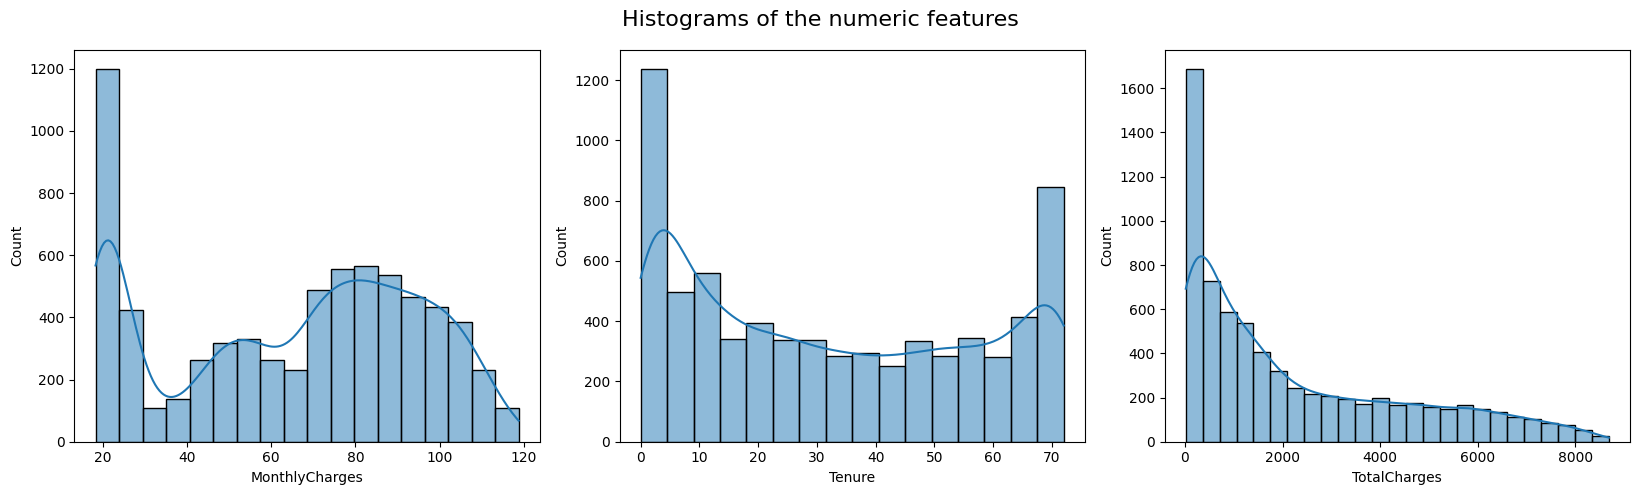

In [46]:
rows, cols = best_grid_shape(len(numeric_features))
#output row = 1, column = 3

fig, axs = plt.subplots(
    rows,
    cols,
    figsize=(5.5 * cols, 5 * rows),
    tight_layout=True,
)
print(fig)
print(axs)

for ax, column in zip(axs.ravel(), numeric_features):
    sns.histplot(
        data=df,
        x=column,
        ax=ax,
        kde=True,
    )

fig.suptitle("Histograms of the numeric features", fontsize=16)
plt.show()

We can see that most customers have been with the company for a very low tenure, in turn also accumulating low monthly and total charges. Many customers however have also been with the company for the longest period possible, 72 months (maximum value). This can be related to another variable, such as the kind of contracts that the people are on.

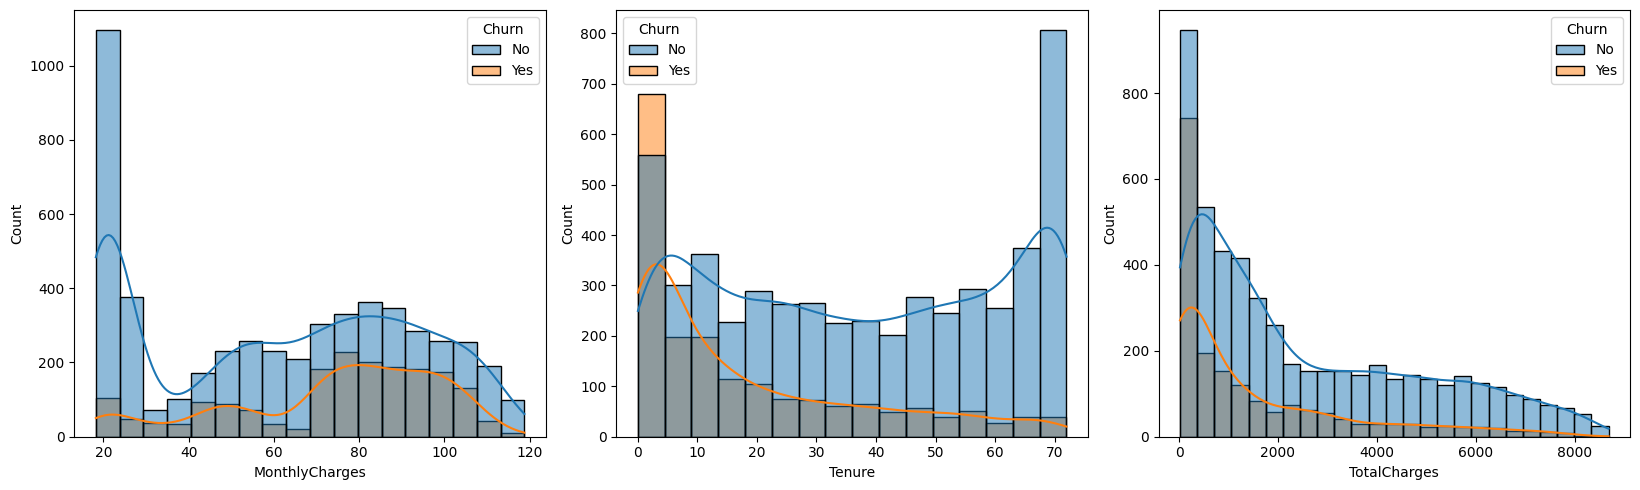

In [47]:
row, col = best_grid_shape(len(numeric_features))
fig, axs = plt.subplots(
    row, col, figsize = (5.5 * col, 5 * row), tight_layout = True
)

for ax, column in zip(axs.ravel(), numeric_features):
  h = sns.histplot(
      data = df,
      x = column,
      ax = ax,
      kde= True,
      hue = target, #This is what would separate graph by target = churn
  )


We can see some interesting patterns. Short tenure customers have higher churn rates, and Longest tenure customers have very low churn rate. Furthermore, churn rate is also higher for customers with high monthly charges ranging around 70-100. Let's check if the features have anything to do with the type of contract that the customers are on

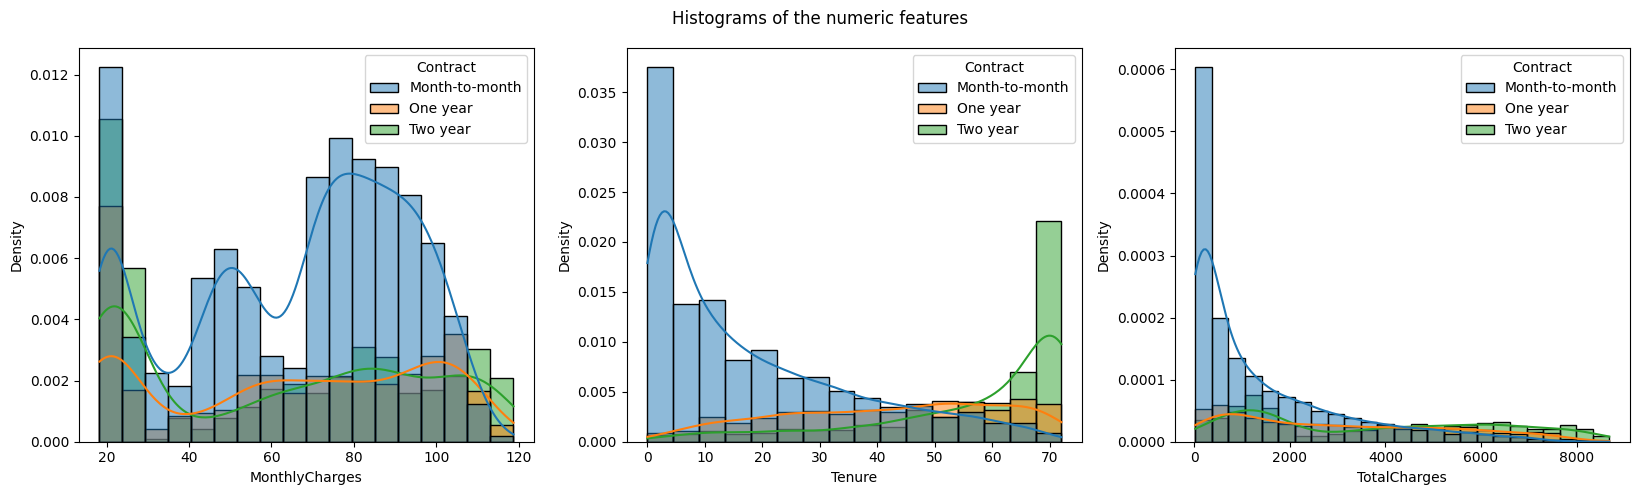

In [48]:
row, col = best_grid_shape(len(numeric_features))
fig, axs = plt.subplots(
    row, col, figsize = (5.5 * col, 5 * row), tight_layout = True
)

for ax, column in zip(axs.ravel(), numeric_features):
  h = sns.histplot(
      data = df,
      x = column,
      ax = ax,
      kde= True,
      hue = "Contract",
      stat = "density",
  )
fig.suptitle("Histograms of the numeric features")

plt.show()

We can see that people with the lowest tenure (correlated with higher churn) are on a month-to-month contract, and the people with the highest tenures are on two year contracts. This implies that customers with a greater commitment at the beginning, tend to stay with the company for a longer period of time. This can potentially be because customers get used to their contract, and feel more resistance towards switching anywhere else. <br>
We can further check the relationship between the contract type and the monthy-total charges with violin plots.

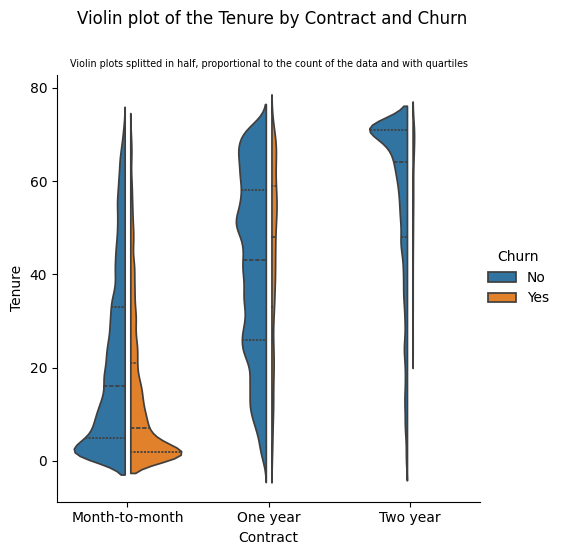

In [49]:
g = sns.catplot(
    data = df,
    x= "Contract",
    y = "Tenure",
    hue = target,
    split = True,
    gap=0.1,
    kind = "violin",
    inner="quartile",
    density_norm="count",
    bw_adjust=0.5,


)
g.ax.set_title(
    "Violin plots splitted in half, proportional to the count of the data and with quartiles",
    fontsize = "x-small",
    loc= "center"
)
g.figure.suptitle("Violin plot of the Tenure by Contract and Churn", y=1.10)
plt.show()


We can see that For the first violinplot, most people under a month to month conract have a tenure close to 0-2 months, with the most amount of churners during this time as well. Perhaps the customers on a month to month contract that have not churned are at the highest risk of churning. Let's keep exploring and check whether the amount these customers are paying might also play a factor <br>
We can check the relationship between the kind of contract and the monthly charges.

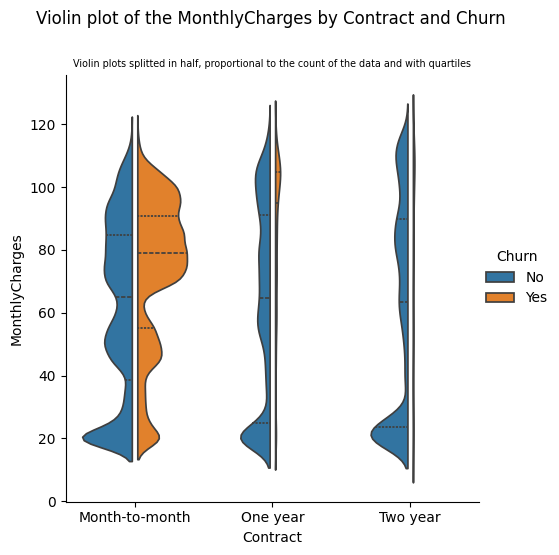

In [50]:
g = sns.catplot(
    data = df,
    x= "Contract",
    y = "MonthlyCharges",
    hue = target,
    split = True,
    gap=0.1,
    kind = "violin",
    inner="quartile",
    density_norm="count",
    bw_adjust=0.5,


)
g.ax.set_title(
    "Violin plots splitted in half, proportional to the count of the data and with quartiles",
    fontsize = "x-small",
    loc= "center"
)
g.figure.suptitle("Violin plot of the MonthlyCharges by Contract and Churn", y=1.10)
plt.show()

We can see the high, broad peak in the violinplot for month-to-month contracts, implying that the highest concentration of churners are on a month to month contract, with high monthly charges ranging from around $70-$100. What are these services that the customers are buying which have high monthly charges? <br>
Let's check how the type of internet service affects churn rate.

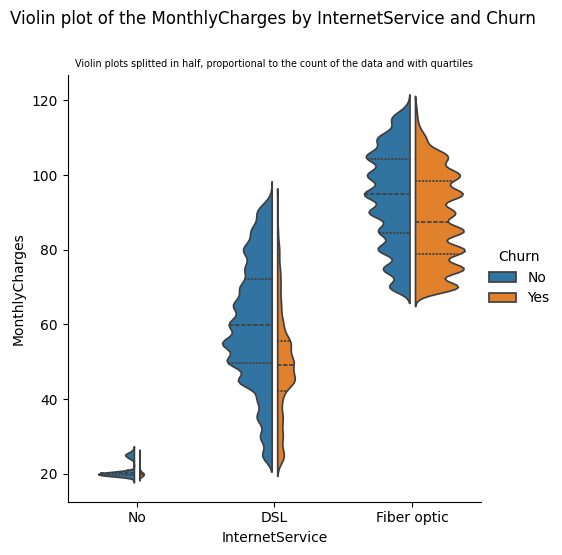

In [51]:
g = sns.catplot(
    data = df,
    x= "InternetService",
    y = "MonthlyCharges",
    hue = target,
    split = True,
    gap=0.1,
    kind = "violin",
    inner="quartile",
    density_norm="count",
    bw_adjust=0.5,


)
g.ax.set_title(
    "Violin plots splitted in half, proportional to the count of the data and with quartiles",
    fontsize = "x-small",
    loc= "center"
)
g.figure.suptitle("Violin plot of the MonthlyCharges by InternetService and Churn", y=1.10)
plt.show()

We can see that the Fiber optic service has a much higher monthly charge. This is probably because fiber optic is faster and more reliable. However the churn rate for fiber optic is also higher. This is most likely because customers are not happy with the value / service they are getting for the price they pay. So customers perhaps think that the extra speed is not worth the extra price.

## Pairplots
Pairplots are a great way to visualize the relationships between the features. It shows the scatter plots of each pair of features and the diagonal shows the distribution of each feature. We can use the hue parameter to color the points according to a categorical feature or the target variable

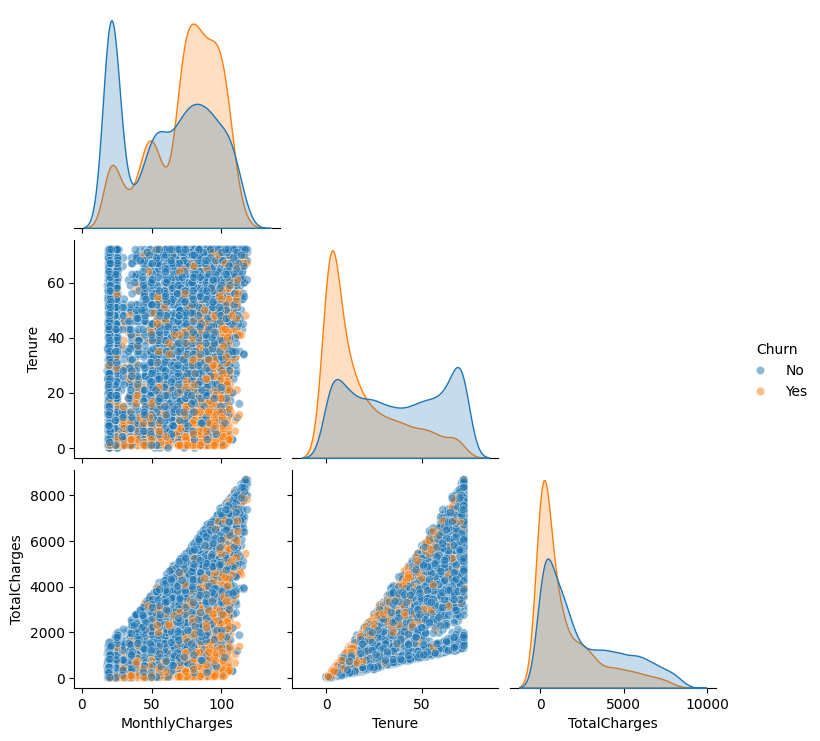

In [54]:
customized_pairplot(df, numeric_features, hue_column=target)

The results are as expected. High multicollinearity for Total charges x tenure, and Monthlycharges x total charges. Churn rate is the highest for Higher monthly charges and lower tenure. Let's check 1 more plot with the senior citizen as the hue.

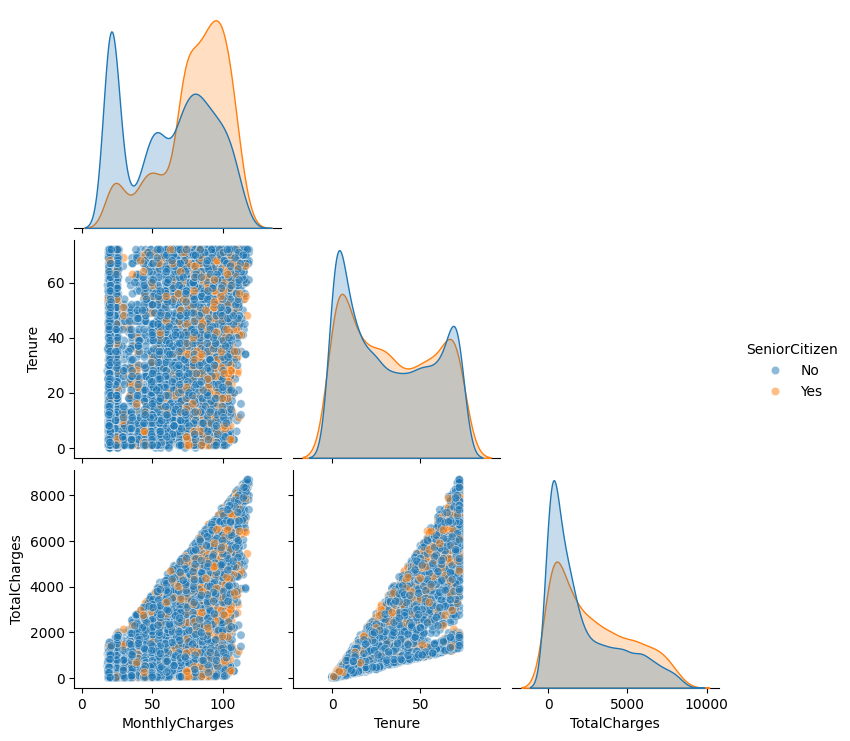

In [55]:
customized_pairplot(df, numeric_features, hue_column="SeniorCitizen")

The plot on the top left tells us that senior citizens are paying higher monthly charges than non senior citizens.

##Categorical Features
Let's find out the proportion of each category in the categorical features:

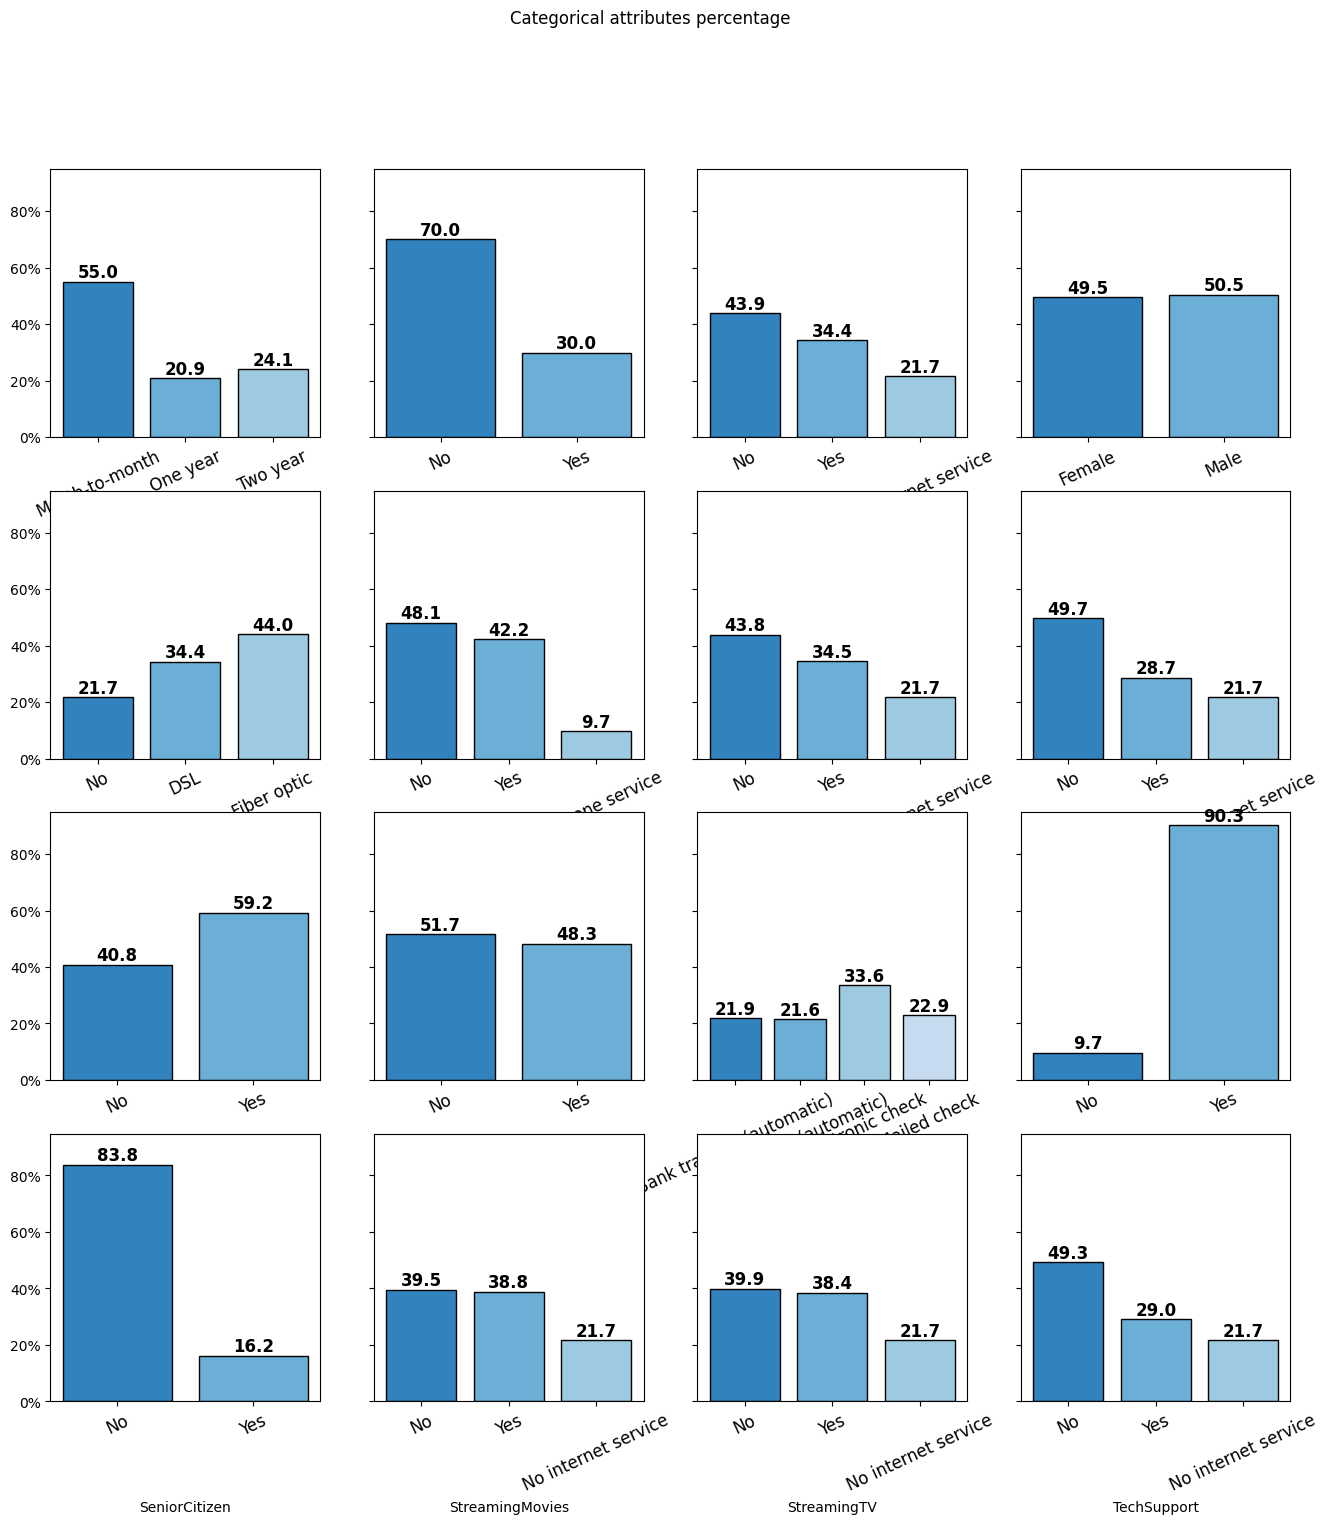

In [56]:
plot_categories_percentages(df, categorical_features)

Some key insights:
- 16.2% of the customers are senior citizens, and most customers are young.
- dataset equally distributed in terms of gender and whether customer has a partner
- 55.0% odf the contracts are month to month.
- 90.3% of the customers have phone service <br>
We see that some categorical features have 'No' and 'No internet service' (or 'No phone service') as categories. Maybe all of them can be labeled as 'No' if the categories provide no additional information. We can check this, plotting the churn rate by category:


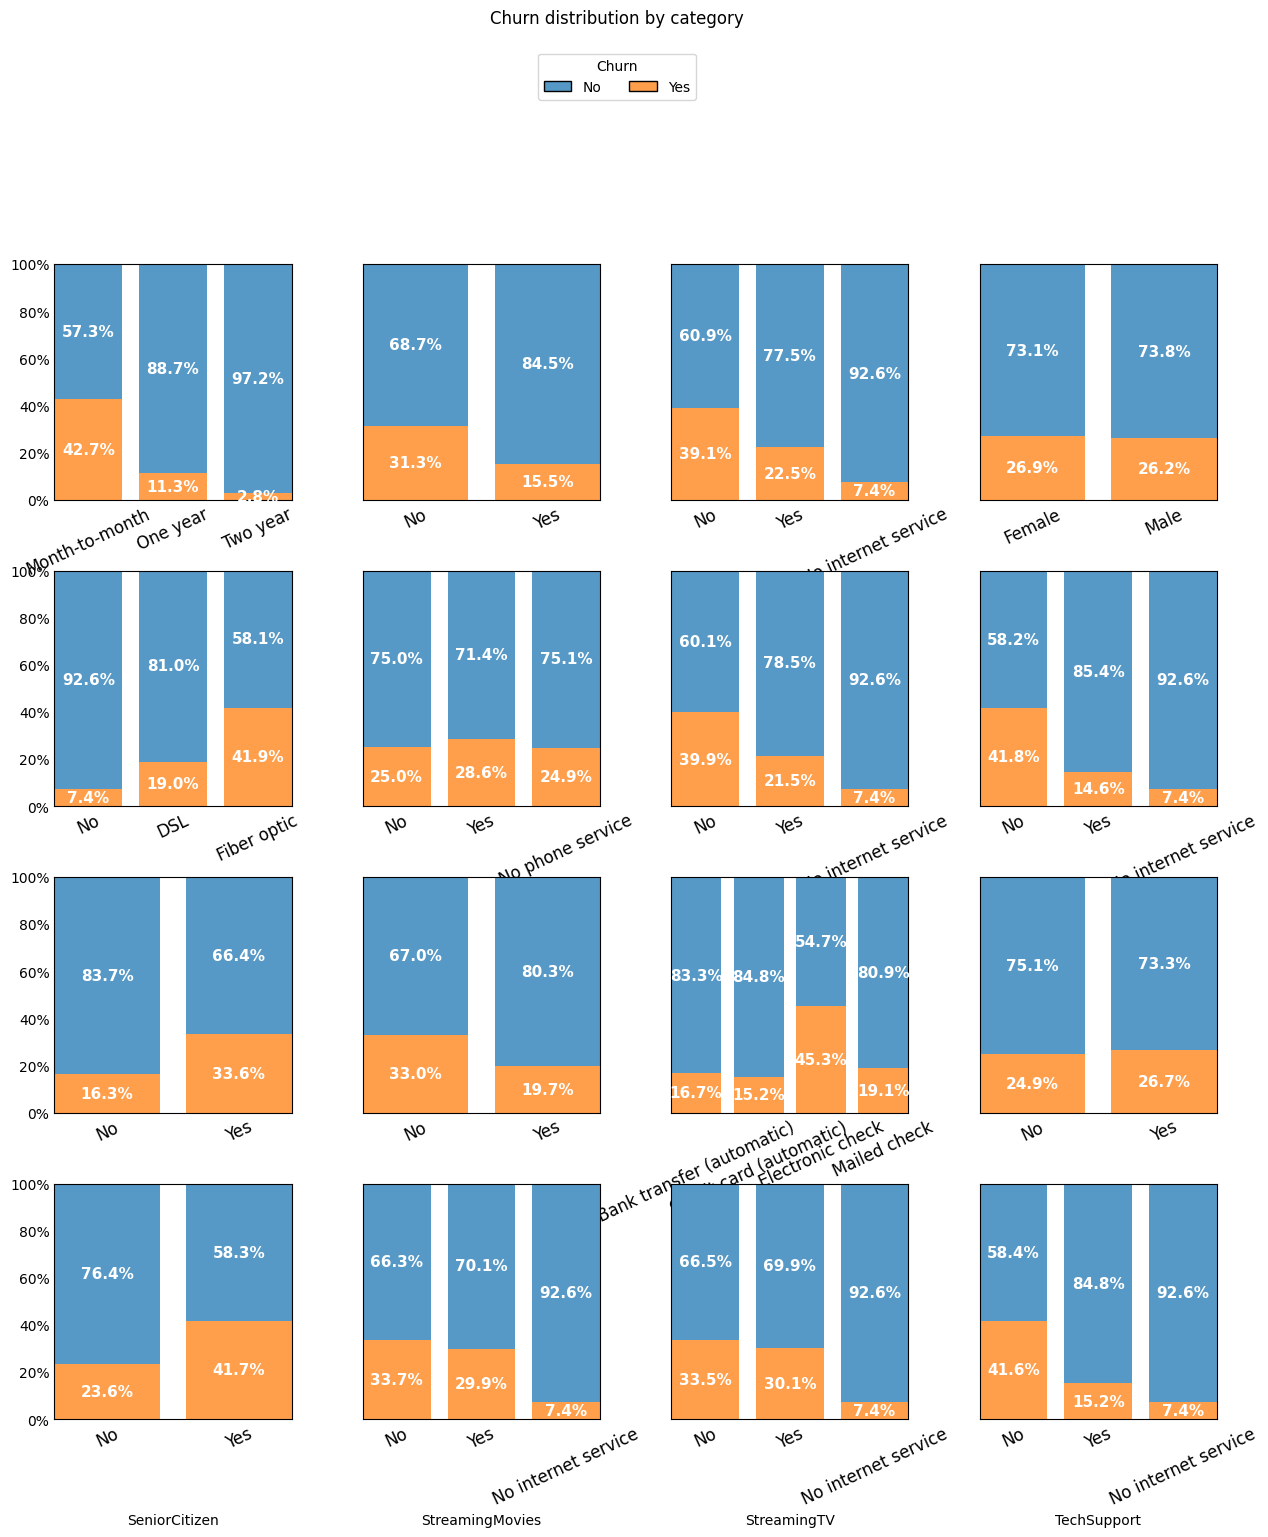

In [57]:
plot_target_distribution_by_category(
    df,
    categorical_features,
    column_target=target,
    figsize=(15, 15),
    legend_title="Churn",
    figure_title="Churn distribution by category",
)

Features that seem to be positivly correlated with churn:
- Month to month contracts
- No device protection, online backup, online security or technical support
- Fiber optic contract
- Senior citizens
- Electronic check payment method

Features that seem to be negatively correlated with churn:
- Two year contract
- No internet service
- Non electronic payment method

We will quantify these correlations soon, biut first let's try to interpret these findings. It is interesting to see that the "No internet service" category has much lower churn rates, so the internet service may have problems such as with the price in the case of the fiber optic or even the performance. <br>
It's also interesting to see how senior citizens are at a higher risk of churning even though they're a small proportion of the customers. Combined with churn's positive correlation with no device protection, online backup, online security or technical support, it nis possible that the internet service might be hard to setup or have issiues, whcih would be eveb more severe in the case of senior citizens. <br>

Let's invert the visual and check for more insights.

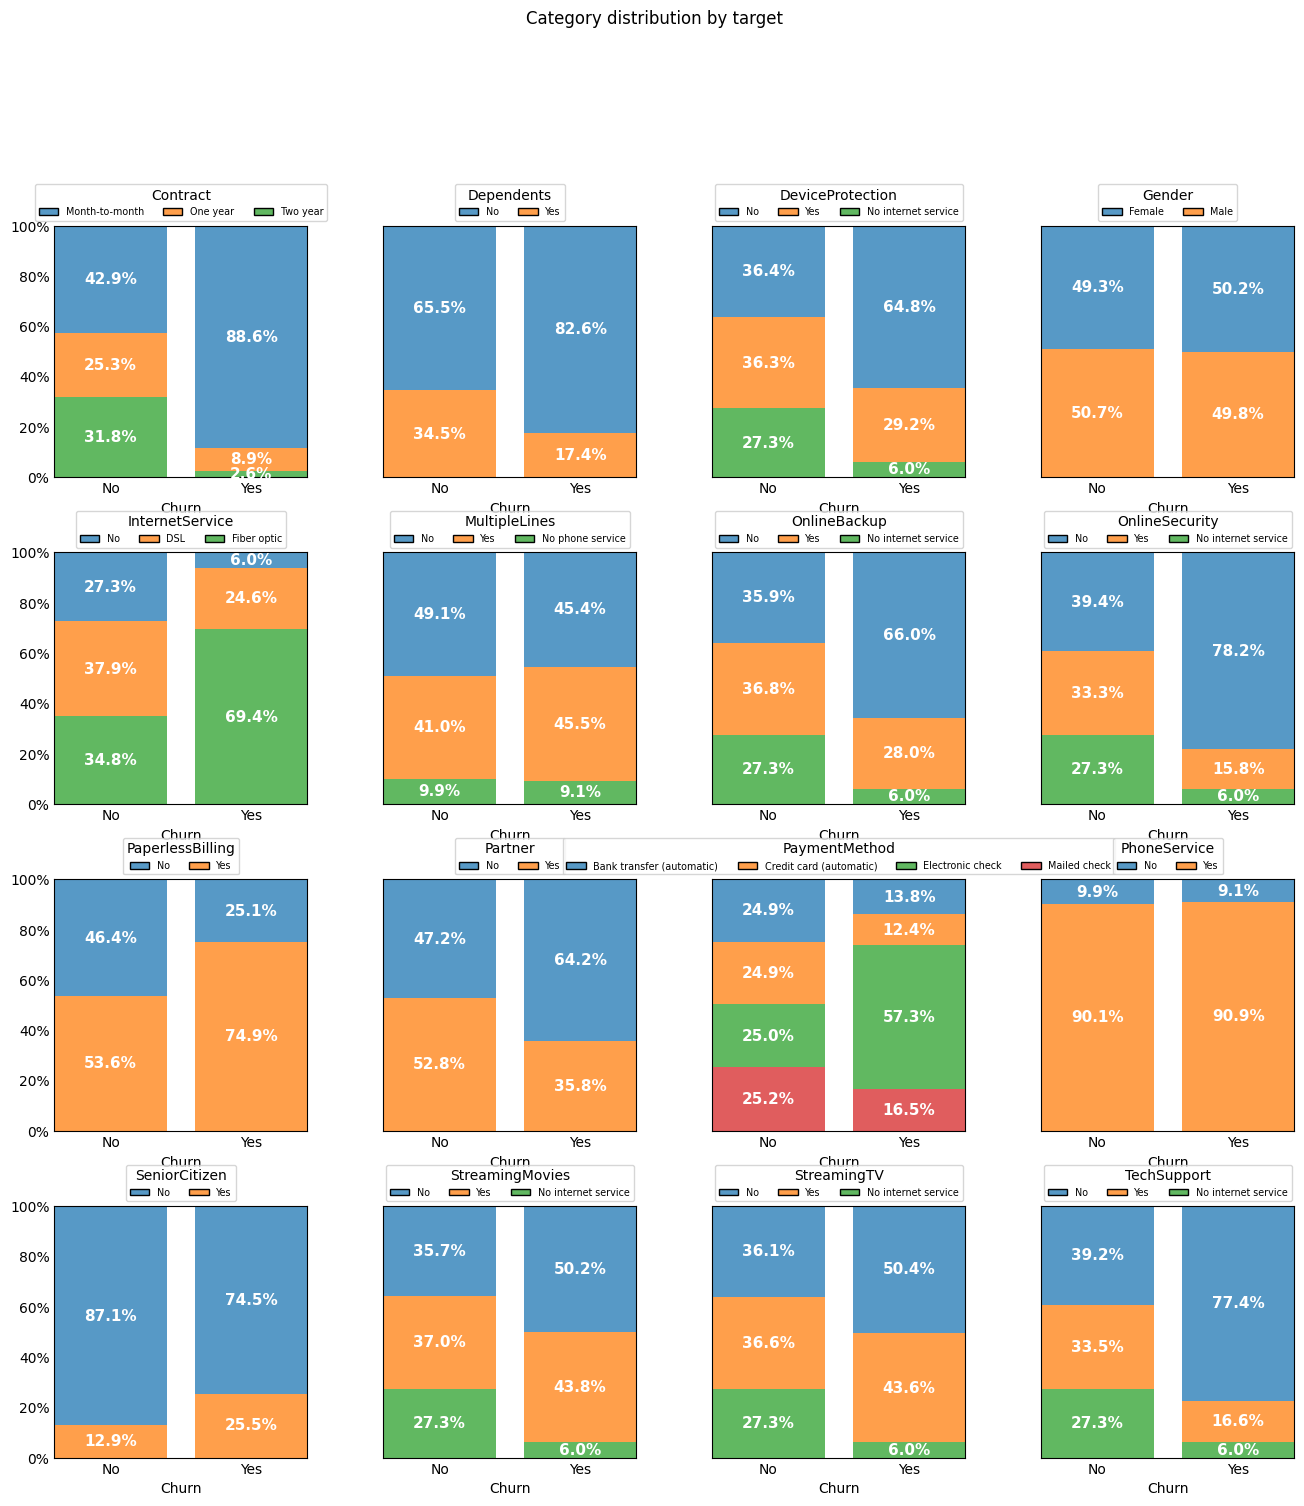

In [58]:
plot_category_distribution_by_target(
    df,
    categorical_features,
    column_target=target,
    figsize=(16, 16)
)


 Customers with partners or dependents have lower churn rates. Probably because more people are involved in the decision of leaving, making it more difficult. For marketing reasons, we can see how many customers who have partners also have dependents. Assuming that, in most cases, "dependents" mean children, it is more likely that customers with partners will also have dependents. Let's check this assumption.

In [64]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total"
)

Dependents,No,Yes,Total
Partner,,,
No,3280,361,3641
Yes,1653,1749,3402
Total,4933,2110,7043


In [61]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total", normalize = True
)

Dependents,No,Yes,Total
Partner,,,
No,0.465711,0.051257,0.516967
Yes,0.234701,0.248332,0.483033
Total,0.700412,0.299588,1.000000


In [62]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total", normalize = "index"
)

Dependents,No,Yes
Partner,,
No,0.900851,0.099149
Yes,0.485891,0.514109
Total,0.700412,0.299588


In [63]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total", normalize = "columns"
)

Dependents,No,Yes,Total
Partner,,,
No,0.66491,0.17109,0.516967
Yes,0.33509,0.82891,0.483033


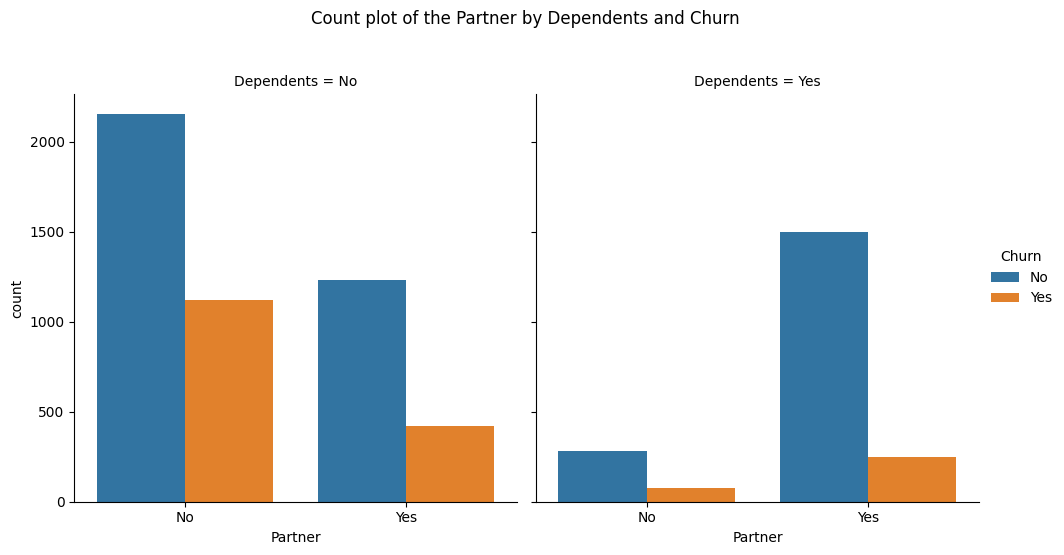

In [66]:
g = sns.catplot(
    data= df,
    x="Partner",
    col="Dependents",
    hue=target,
    kind="count",
)
g.figure.suptitle("Count plot of the Partner by Dependents and Churn", y=1.10)
plt.show()


Almost half of the customers with partners have dependents. Again, assuming that in most cases "dependents" mean children, this means that marketing campaigns which aim at avoiding churn may focus on single people.

##Statistical Tests